In part 3, we computed the linguistic divergence between two corpora consisting of texts from **r/MensRights** and **r/Feminism** respectively, and we had some idea about how the linguistic distance between the two subreddits has evolved over time.

Note that in part 3 the corpus from **r/MensRights** or **r/Feminism** was represented as counters of words (e.g. `{"apple": 2, "pen": 3, "pineapple": 1, ...}`), which is essentially the same as unigram language model.

In this part we'll perform further analysis to quantitatively measure the linguistic distance between the two subreddits. First we'll train a bigram language model ([language_model.py](https://github.com/chao-ji/reddit/blob/master/language_model.py)) using the corpus from one subreddit, which will be used to evaluate the sentence probabilities within different time intervals from the other subreddit. Then we'll extend the analysis to the semantic level: we'll make use of the vector representation of text and compute the linguistic distance based on vector arithmetics.

In [1]:
import datetime
import itertools
import pickle

import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_distances

from language_model import *

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))
sw.update(stopwords.words("english"))

First we need to create a generator for the text data. The text data is too large to fit in memory. To train and evaluate the the bigram model, we only need traverse the data in one pass.

In [2]:
def men_corpus():
    for doc in db["MensRights"].find({}, {"created_utc": 1, "tokens": 1, "_id": 0}).sort("created_utc", pymongo.ASCENDING):
        tokens = doc["tokens"].split()
        if len(tokens) >= 30:
            yield tokens
            
def fem_corpus():
    for doc in db["Feminism"].find({}, {"created_utc": 1, "tokens": 1, "_id": 0}).sort("created_utc", pymongo.ASCENDING):
        tokens = doc["tokens"].split()
        if len(tokens) >= 2:
            yield tokens       

The probabilities computed in bigram model was smoothed using Good-Turing method, for which we need to find the number of words in the testing corpus that do not show up in the training corpus (aka *out-of-vocabulary* words). 

Because we'll swtich the roles of two corpora, we'll compute the number of *out-of-vocabulary* words separately for **r/MensRights** and **r/Feminism**.

In [3]:
corpus_men_tokens = set()

for tokens in men_corpus():
        corpus_men_tokens.update(tokens)
        
corpus_fem_tokens = set()

for tokens in fem_corpus():
        corpus_fem_tokens.update(tokens)

# out-of-vocabulary for rMR: words in rFem that are not present in rMR
oov_men = len(corpus_fem_tokens - corpus_men_tokens)
# out-of-vocabulary for rFem: words in rMR that are not present in rFem
oov_fem = len(corpus_men_tokens - corpus_fem_tokens)
del corpus_fem_tokens, corpus_men_tokens

In [4]:
# Train bigram model on rMR corpus
bigram_men = Bigram(special_token=False)
bigram_men = bigram_men.fit(men_corpus(), oov_men)

In [5]:
# Define helper function that computes the avearge of the log-transformed
# probabilities of posts in subreddit `subreddit` and in date `d`

def eval_sentprob(subreddit, model, d):
    if d.month == 1 and d.day == 1:
        print d
        
    docs = db[subreddit].find({"date": d}, {"date": 1, "tokens": 1, "_id": 0})
    test_corpus = map(lambda d: d["tokens"].split(), docs)
    test_corpus = filter(lambda x: len(x) >= 2, test_corpus)
    probs = np.array(map(lambda x: model.predict(x), test_corpus))
    probs = probs[~np.isnan(probs)]
    if len(probs) > 0:
        return np.mean(probs)
    else:
        return np.nan

In [6]:
# Compute the average of log-probabilities of sentenfce 

dates = map(lambda d: d["date"], db["Feminism"].find({}, {"date": 1, "_id": 0}))
dates = sorted(list(set(dates)))
test_probs = map(lambda x: eval_sentprob("Feminism", bigram_men, x), dates)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [7]:
# Build series object with dates as the index
ser = pd.Series(test_probs, index=dates)
ser = ser[ser.notnull()]
ser[-10:]

Plot the average of log-probabilities over all posts in rFem for each day

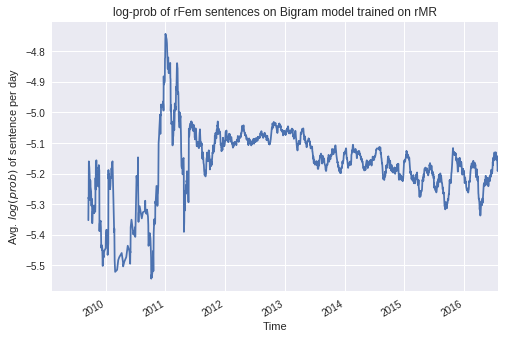

In [9]:
ser = ser.rolling(window=30).mean()
ser.plot()
plt.title("log-prob of rFem sentences on Bigram model trained on rMR")
plt.ylabel("Avg. $log(prob)$ of sentence per day")
plt.xlabel("Time")
plt.show()

In [10]:
del bigram_men
# Train bigram model on rMR corpus

bigram_fem = Bigram(special_token=False)
bigram_fem = bigram_fem.fit(fem_corpus(), oov_fem)

In [11]:
# Compute the average of log-probabilities of sentenfce 

dates = map(lambda d: d["date"], db["MensRights"].find({}, {"date": 1, "_id": 0}))
dates = sorted(list(set(dates)))
test_probs = map(lambda x: eval_sentprob("MensRights", bigram_fem, x), dates)

2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [12]:
# Build series object with dates as the index

ser = pd.Series(test_probs, index=dates)
ser = ser[ser.notnull()]
ser[-10:]

Plot the average of log-probabilities over all posts in rFem for each day

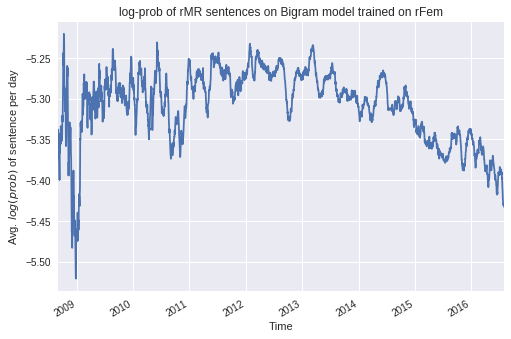

In [14]:
ser = ser.rolling(window=30).mean()
ser = ser[120:]
ser.plot()
plt.title("log-prob of rMR sentences on Bigram model trained on rFem")
plt.ylabel("Avg. $log(prob)$ of sentence per day")
plt.xlabel("Time")
plt.show()

Note that we don't have as many posts in earlier 

In [15]:
del bigram_fem

import warnings
warnings.simplefilter('ignore')
    
from gensim import models
model = models.Doc2Vec.load("doc2vec_dbow_d100_n5_w15_mc5_s1e_05_t6.model")

In [16]:
def thread(df):
    s = df.groupby("author").apply(lambda author_df: set(author_df["link_id"].unique()))
    return s.to_dict()

In [17]:
men_posts = pd.DataFrame(list(db["MensRights"].find({}, {"date": 1, "created_utc": 1, "link_id": 1,
                                                         "author": 1, "_id": 1}).sort("created_utc",
                                                                                      pymongo.ASCENDING)))

fem_posts = pd.DataFrame(list(db["Feminism"].find({}, {"date": 1, "created_utc": 1, "link_id": 1,
                                                       "author": 1, "_id": 1}).sort("created_utc",
                                                                                    pymongo.ASCENDING)))

men_posts = men_posts[men_posts["_id"].map(lambda x: str(x) in model.docvecs)]
fem_posts = fem_posts[fem_posts["_id"].map(lambda x: str(x) in model.docvecs)]

In [18]:
men_posts[:10]

,_id,author,created_utc,date,link_id
0,57c657db79a3030ce0379124,kanuk876,2008-03-21 15:35:09,2008-03-21,t3_6cx14
1,57c657dc79a3030ce0380a72,WorcesterM,2008-03-24 09:05:47,2008-03-24,t3_6d4ku
2,57c657dc79a3030ce0385021,WorcesterM,2008-03-25 11:54:29,2008-03-25,t3_6db9x
3,57c657dc79a3030ce03855c1,linuxlass,2008-03-25 13:27:03,2008-03-25,t3_6db9x
4,57c657dd79a3030ce0388c35,Xiphorian,2008-03-26 09:41:00,2008-03-26,t3_6cv4i
11,57c657e579a3030ce03cc184,andymikey,2008-04-13 15:53:04,2008-04-13,t3_6flx4
13,57c657e979a3030ce03eb88d,Xiphorian,2008-04-21 23:41:30,2008-04-21,t3_6gm6f
15,57c657ea79a3030ce03ee833,Xiphorian,2008-04-22 16:31:14,2008-04-22,t3_6gq5w
16,57c657ea79a3030ce03f3b1d,yojustkeepitreal,2008-04-23 19:27:39,2008-04-23,t3_6gu4k
18,57c657ee79a3030ce040b25c,linuxlass,2008-04-29 17:18:57,2008-04-29,t3_6hh45


In [19]:
fem_posts[:10]

,_id,author,created_utc,date,link_id
4,57c655e779a3030ce04be7d5,cyborg_selkie,2009-05-12 23:39:24,2009-05-12,t3_8k0db
7,57c6562979a3030ce06b6c95,Cassio,2009-07-02 19:02:15,2009-07-02,t3_8k0db
8,57c6563479a3030ce0701e1f,AnnArchist,2009-07-09 17:27:42,2009-07-09,t3_8zsla
9,57c6563579a3030ce0705285,Kowai03,2009-07-09 23:01:30,2009-07-09,t3_8zsla
11,57c6563679a3030ce0713754,nuuur32,2009-07-11 02:47:08,2009-07-11,t3_8g9mx
14,57c6565f79a3030ce0857526,Cassio,2009-08-07 06:55:32,2009-08-07,t3_98ds7
15,57c6566579a3030ce0882abf,SwampGass,2009-08-10 18:19:39,2009-08-10,t3_98scn
16,57c6566579a3030ce0882c6a,SwampGass,2009-08-10 18:27:49,2009-08-10,t3_977zr
17,57c6566679a3030ce088ea23,Aerik,2009-08-11 15:11:40,2009-08-11,t3_8x7nn
24,57c6568179a3030ce0948ad9,Naughtymonkey,2009-08-24 18:43:46,2009-08-24,t3_9dqpz


In [20]:
common_date = sorted(list(set(men_posts["date"]) & set(fem_posts["date"])))

In [21]:
len(common_date)

2148

In [22]:
men_by_date = men_posts.groupby("date").apply(lambda df: df.groupby("author").apply(lambda x: list(x["_id"])).to_dict())
fem_by_date = fem_posts.groupby("date").apply(lambda df: df.groupby("author").apply(lambda x: list(x["_id"])).to_dict())

In [23]:
men_by_date.shape, fem_by_date.shape

((2982,), (2148,))

In [24]:
def semantic_dist_between(date):
    if date.month == 1 and date.day == 1:
        print date

    radius = 15
    dates = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    l1 = [list(itertools.chain(*men_by_date[d].values()) ) for d in dates if d in men_by_date]
    l2 = [list(itertools.chain(*fem_by_date[d].values()) ) for d in dates if d in fem_by_date]
    l1 = list(itertools.chain(*l1))
    l2 = list(itertools.chain(*l2))
    
    X1 = np.array([model.docvecs[str(one_id)] for one_id in l1])
    X2 = np.array([model.docvecs[str(one_id)] for one_id in l2])
    
    return cosine_distances(X1, X2).mean()

In [25]:
a = map(lambda d: semantic_dist_between(d), common_date)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


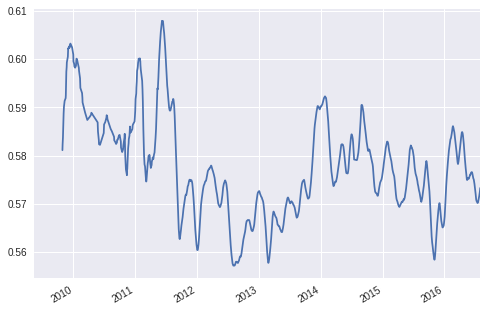

In [26]:
s = pd.Series(a, index=common_date)
s = pd.rolling_mean(s, window=30)
s.plot()
plt.show()

In [27]:
del men_posts, fem_posts, men_by_date, fem_by_date, model